In [1]:
# Import modules
import os
import glob
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from fiona.crs import from_epsg
from shapely.geometry import box
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import matplotlib.ticker as ticker


import gdal

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


def reproject_to_template(input_raster, template_raster, output_raster, resolution=None,
                          resampling=gdal.GRA_Bilinear, nodata_val=0):
    """
    Reprojects a raster to match the extent, cell size, projection and dimensions of a template
    raster using GDAL. Optionally, can set custom resolution for output reprojected raster using
    'resolution'; this will affect raster dimensions/width/columns.

    Last modified: April 2018
    Author: Robbi Bishop-Taylor

    :param input_raster:
        Path to input geotiff raster to be reprojected (.tif)

    :param template_raster:
        Path to template geotiff raster (.tif) used to copy extent, projection etc

    :param output_raster:
        Output reprojected raster path with geotiff extension (.tif)

    :param resolution:
        Optionally set custom cell size for output reprojected raster; defaults to
        'None', or the cell size of template raster

    :param resampling:
        GDAL resampling method to use for reprojection; defaults to gdal.GRA_Bilinear

    :param nodata_val:
        Values in the output reprojected raster to set to nodata; defaults to 0

    :return:
        GDAL dataset for further analysis, and raster written to output_raster (if this
        dataset appears empty when loaded into a GIS, close the dataset like 'output_ds = None')

    """

    # Import raster to reproject
    print("Importing raster datasets")
    input_ds = gdal.Open(input_raster)
    input_proj = input_ds.GetProjection()
    input_geotrans = input_ds.GetGeoTransform()
    data_type = input_ds.GetRasterBand(1).DataType
    n_bands = input_ds.RasterCount

    # Import raster to use as template
    template_ds = gdal.Open(template_raster)
    template_proj = template_ds.GetProjection()
    template_geotrans = template_ds.GetGeoTransform()
    template_w = template_ds.RasterXSize
    template_h = template_ds.RasterYSize

    # Use custom resolution if supplied
    if resolution:
        template_geotrans[1] = float(resolution)
        template_geotrans[-1] = -float(resolution)

    # Create new output dataset to reproject into
    output_ds = gdal.GetDriverByName('Gtiff').Create(output_raster, template_w,
                                                     template_h, n_bands, data_type)
    output_ds.SetGeoTransform(template_geotrans)
    output_ds.SetProjection(template_proj)
    output_ds.GetRasterBand(1).SetNoDataValue(nodata_val)

    # Reproject raster into output dataset
    print("Reprojecting raster")
    gdal.ReprojectImage(input_ds, output_ds, input_proj, template_proj, resampling)

    # Close datasets
    input_ds = None
    template_ds = None

    print("Reprojected raster exported to {}".format(output_raster))
    return output_ds


def clip_NIDEM_layers(path_dict, x_topleft, y_bottomright, x_bottomright, y_topleft):

    # Create bounding box
    bbox = box(x_topleft, y_bottomright, x_bottomright, y_topleft)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(3577))
    coords = getFeatures(geo)

    array_dict = {}

    for dataset, path in path_dict.items():

        # Import data and clip
        data = rasterio.open(path)
        out_img, out_transform = mask(data, shapes=coords, crop=True)

        # Fix any nodata in dataset
        out_img = out_img.astype(np.float)
        out_img[out_img == -6666] = np.nan
        out_img[out_img == -9999] = np.nan

        # Copy the metadata
        out_meta = data.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_img.shape[1],
                         "width": out_img.shape[2],
                         "transform": out_transform})

        # Assign array to dict
        array_dict[dataset] = out_img[0, :, :]
        
    return array_dict

# Working directory
os.chdir('/g/data/r78/rt1527/nidem')


# # Reproject SRTM-derived 1 Second DEM to cell size and projection of NIDEM
# reproject_to_template(input_raster='/g/data/rr1/Elevation/1secSRTM_DEMs_v1.0/DEM/Mosaic/dem1sv1_0',
#                       template_raster=path_dict['nidem_dem'],
#                       output_raster='scratch/srtm_raster.tif',
#                       nodata_val=-9999)

# # Reproject GBR30 bathymetry to cell size and projection of NIDEM
# reproject_to_template(input_raster='/g/data/r78/rt1527/datasets/GBR30/02_ESRI_Raster/gbr30_ALL/gbr30_all',
#                       template_raster=path_dict['nidem_dem'],
#                       output_raster='scratch/gbr30_raster.tif',
#                       nodata_val=-9999)


## Flowchart figure

In [ ]:
# Clip data to buffer 
lat, lon = -20.9700620057, 149.085064352
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
x_topleft, x_bottomright = (x - 8500, x + 8500)
y_topleft, y_bottomright = (y - 7000, y + 7000)

# Dict of file paths
polygon_ID = 66
path_dict = {'nidem_dem': 'output_data/geotiff/dem/NIDEM_dem_{}.tif'.format(polygon_ID), 
             'nidem_unfiltered': 'output_data/geotiff/dem_unfiltered/NIDEM_unfiltered_{}.tif'.format(polygon_ID),
             'nidem_mask': 'output_data/geotiff/mask/NIDEM_mask_{}.tif'.format(polygon_ID),
             'item_relative': glob.glob('/g/data2/v10/ITEM/rel_products/ITEM_REL_{}_*.tif'.format(polygon_ID))[0],
             'item_confidence': glob.glob('/g/data2/v10/ITEM/conf_products/ITEM_STD_{}_*.tif'.format(polygon_ID))[0],
             'srtm': 'scratch/srtm_raster.tif',
             'gbr30': 'scratch/gbr30_raster.tif'}

array_dict = clip_NIDEM_layers(path_dict, x_topleft, y_bottomright, x_bottomright, y_topleft)

# Plot SRTM
fig, ax = plt.subplots() 
fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
fig.set_size_inches(12,10)
ax.axis('off')
plt.imshow(array_dict['srtm'], cmap='Greys_r', vmin= -10, vmax = 50)
# fig.savefig("figures/{}.png".format('srtm'), pad_inches = 0)

# # Plot GBR30
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['gbr30'], cmap='Greys_r', vmin= -15, vmax = 10)
# fig.savefig("figures/{}.png".format('gbr30'), pad_inches = 0)

# # Plot NIDEM 
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['nidem_dem'], cmap='viridis')
# fig.savefig("figures/{}.png".format('nidem_dem'), pad_inches = 0)

# # Plot NIDEM unfiltered
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['nidem_unfiltered'], cmap='viridis')
# fig.savefig("figures/{}.png".format('nidem_unfiltered'), pad_inches = 0)

# # Plot NIDEM  raw
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['nidem_raw'], cmap='viridis')
# fig.savefig("figures/{}.png".format('nidem_raw'), pad_inches = 0)

# # Plot NIDEM mask
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# item_cs = ['dimgrey', 'dimgrey', 'dimgrey']
# item_cm = LinearSegmentedColormap.from_list('item', item_cs, N=3)
# plt.imshow(array_dict['nidem_mask'], cmap=item_cm, interpolation='bilinear')
# fig.savefig("figures/{}.png".format('nidem_mask'), pad_inches = 0)

# # Plot ITEM relative
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# item_cs = ['white', '#2b83ba', '#74b6ad', '#b7e1a7', '#e7f5b7', 
#            '#fee7a4', '#fdb96e', '#ec6e43', '#d7191c', '#b81518']  # '#1a6a9d'
# item_cm = LinearSegmentedColormap.from_list('item', item_cs, N=10)
# plt.imshow(array_dict['item_relative'], cmap=item_cm, interpolation='bilinear')
# fig.savefig("figures/{}.png".format('item_relative'), pad_inches = 0)

# # Plot ITEM confidence
# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# plt.imshow(array_dict['item_confidence'], cmap='RdYlBu_r', interpolation='bilinear')
# fig.savefig("figures/{}.png".format('item_confidence'), pad_inches = 0)

# # Plot contours
# contour_shp = gpd.GeoDataFrame.from_file('/g/data/r78/rt1527/nidem/output_data/contour/NIDEM_contours_66.shp')

# fig, ax = plt.subplots() 
# fig.subplots_adjust(left=-0.01, bottom=-0.01, right=1.01, top=1.01, wspace=0, hspace=0)
# fig.set_size_inches(12,10)
# ax.axis('off')
# contour_shp.intersection(geo.unary_union).plot(ax = ax, alpha=0.5, edgecolor='black')
# fig.savefig("figures/{}.png".format('contours'), pad_inches = 0)

## Offset and spread plots

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=3)

cmap_name = 'magma'

# Import polygons and values from file
item_polygons = gpd.read_file('/g/data2/v10/ITEM/ITEMv2_tidalmodel.shp')
offsetspread_df = pd.read_csv('/g/data/r78/rt1527/item_classification/output_data/item_offset_spread_1-306.csv')

# Join 
joined_polygons = item_polygons.merge(offsetspread_df, on='ID')
joined_polygons['geometry'] = item_polygons['geometry']

# Plot 
figure, (axes) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(4.5, 17))
joined_polygons.plot(column='spread', ax = axes[0], linewidth=0.35, edgecolor='black', cmap='magma_r')
joined_polygons.plot(column='offset_low', ax = axes[1], linewidth=0.35, edgecolor='black', cmap=cmap_name)
joined_polygons.plot(column='offset_high', ax = axes[2], linewidth=0.35, edgecolor='black', cmap=cmap_name)

# Fix spacing
axes[0].set_aspect(1)
axes[1].set_aspect(1)
axes[2].set_aspect(1)
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
plt.subplots_adjust(left=0, wspace=0, hspace=0.05)
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)



# Create colorbar as a legend
fig = axes[0].get_figure()
cax = fig.add_axes([0.12, 0.675, 0.3, 0.01])
sm = plt.cm.ScalarMappable(cmap='magma_r', 
                           norm=plt.Normalize(vmin=np.round(joined_polygons['spread'].min(),1), 
                                              vmax=joined_polygons['spread'].max()))

# empty array for the data range and add the colorbar to the figure
sm._A = []
cbar = fig.colorbar(sm, orientation='horizontal', cax=cax)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_title('Spread', fontname='Carlito')
plt.xticks(fontname = "Carlito") 




# Create colorbar as a legend
fig2 = axes[1].get_figure()
cax2 = fig2.add_axes([0.12, 0.4175, 0.3, 0.01])
sm2 = plt.cm.ScalarMappable(cmap=cmap_name, 
                           norm=plt.Normalize(vmin=np.round(joined_polygons['offset_low'].min(), 1), 
                                              vmax=joined_polygons['offset_low'].max()))

# empty array for the data range and add the colorbar to the figure
sm2._A = []
cbar2 = fig2.colorbar(sm2, orientation='horizontal', cax=cax2)
cbar2.locator = tick_locator
cbar2.update_ticks()
cbar2.ax.set_title('Offset (low)', fontname='Carlito')
plt.xticks(fontname = "Carlito") 




# Create colorbar as a legend
fig3 = axes[2].get_figure()
cax3 = fig3.add_axes([0.12, 0.16, 0.3, 0.01])
sm3 = plt.cm.ScalarMappable(cmap=cmap_name, 
                           norm=plt.Normalize(vmin=np.round(joined_polygons['offset_high'].min(), 1), 
                                              vmax=joined_polygons['offset_high'].max()))

# empty array for the data range and add the colorbar to the figure
sm3._A = []
cbar3 = fig3.colorbar(sm3, orientation='horizontal', cax=cax3)
cbar3.locator = tick_locator
cbar3.update_ticks()
cbar3.ax.set_title('Offset (high)', fontname='Carlito')
plt.xticks(fontname = "Carlito") 


axes[0].annotate('a)',
            xy=(0.205, 0.91), xycoords='figure fraction',
            fontsize=18, fontname='Carlito', fontweight='bold')
axes[1].annotate('b)',
            xy=(0.205, 0.605), xycoords='figure fraction',
            fontsize=18, fontname='Carlito', fontweight='bold')
axes[2].annotate('c)',
            xy=(0.205, 0.30), xycoords='figure fraction',
            fontsize=18, fontname='Carlito', fontweight='bold')

# Export
figure.savefig("figures/Offset_figure/FigureX_offsetspread.png", pad_inches = 0, dpi=200, bbox_inches='tight')

## Tidal plots

In [ ]:
# Import all modules
import os
import glob
import datacube
import fiona
import pandas as pd
import numpy as np
import datetime as dt
import gc
import itertools
from datacube.utils import geometry
from datacube.api.query import query_group_by
from otps import TimePoint, predict_tide
from dateutil.relativedelta import relativedelta
import geopandas as gpd

# Set up matplotlib to not show plots
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

dc = datacube.Datacube(app='Tidal ITEM plots')


def date_range(start_date, end_date, increment, period):
    
    """Generate dates seperated by given time increment/period"""
    
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result


# Setup

filepath='/g/data/r78/intertidal/GA_native_tidal_model.shp'
products = ['ls5_pq_albers', 'ls7_pq_albers', 'ls8_pq_albers'] 
time_period = ('1986-01-01', '2018-01-01')  # Global time range
ls7_slc_period = ('1986-01-01', '2003-05-01')  # Removes SLC failure

# List of files
item_files = sorted(glob.glob("/g/data/fk4/datacube/002/ITEM/ITEM_2_0/geotiff/ITEM_REL*tif"))
item_df = pd.DataFrame({'strings': item_files})
item_df = pd.DataFrame(item_df.strings.str.split('_|.tif').tolist(), columns=['temp1', 'temp2', 'temp3',
                                                                              'temp4', 'temp5', 'polygon',
                                                                              'lon', 'lat', 'temp6'])
item_df["basename"] = [os.path.basename(item_file)[0:-4] for item_file in item_files]
item_df = item_df.drop(['temp1', 'temp2', 'temp3', 'temp4', 'temp5', 'temp6'], axis=1).sort_values(by=["polygon"])



# plot_dict = {'80': [(0.92, 0.78), (0.92, 0.485), (0.92, 0.182)],
#              '142': [(0.92, 0.841), (0.92, 0.58), (0.92, 0.230)],
#              '158': [(0.925, 0.75), (0.925, 0.43), (0.925, 0.155)]}


plot_dict = {'242': [(0.925, 0.837), (0.925, 0.5), (0.925, 0.13)]}


for polygon in plot_dict.keys():
    
#     # Iterate over polygons
#     polygon_data = item_df[item_df.polygon == polygon]
#     _, lon, lat, basename = polygon_data.values[0]
#     print("Processing {}".format(basename))


#     #################################
#     print("   Model tide heights")  #
#     #################################

#     # For each hour between start and end of timeperiod, create list of datetimes
#     start = dt.datetime.strptime(time_period[0], "%Y-%m-%d")
#     end = dt.datetime.strptime(time_period[1], "%Y-%m-%d")
#     all_times = date_range(start, end, 1, 'hours')

#     # For each timestep in list, predict tide and add to list
#     tp_model = [TimePoint(float(lon), float(lat), dt) for dt in all_times]
#     tides_model = [tide.tide_m for tide in predict_tide(tp_model)]

#     # Covert to dataframe of observed dates and tidal heights
#     df2_model = pd.DataFrame({'Model_height': tides_model}, index=pd.DatetimeIndex(all_times))
    

#     ####################################
#     print("   Observed tide heights")  #
#     ####################################

#     polygons_gpd = gpd.read_file('/g/data/r78/intertidal/GA_native_tidal_model.shp')
#     polygon_gpd = polygons_gpd[polygons_gpd.ID == int(polygon)]
#     poly = next(polygon_gpd.iterfeatures())
#     geom = geometry.Geometry(poly['geometry'], crs=geometry.CRS(polygon_gpd.crs['init']))

#     all_times_obs = list()

#     # For each product:
#     for source in products:

#         # Use entire time range unless LS7
#         time_range = ls7_slc_period if source == 'ls7_pq_albers' else time_period

#         # Determine matching datasets for geom area and group into solar day
#         ds = dc.find_datasets(product=source, time=time_range, geopolygon=geom)
#         group_by = query_group_by(group_by='solar_day')
#         sources = dc.group_datasets(ds, group_by)

#         # If data is found, add time to list then sort
#         if len(ds) > 0:
#             all_times_obs.extend(sources.time.data.astype('M8[s]').astype('O').tolist())

#     # Calculate tide data from X-Y-time location
#     all_times_obs = sorted(all_times_obs)
#     # times_obs = [dt.strftime('%Y-%m-%d') for dt in all_times_obs]
#     tp_obs = [TimePoint(float(lon), float(lat), dt) for dt in all_times_obs]
#     tides_obs = [tide.tide_m for tide in predict_tide(tp_obs)]

#     # Covert to dataframe of observed dates and tidal heights
#     df1_obs = pd.DataFrame({'Tide_height': tides_obs}, index=pd.DatetimeIndex(all_times_obs))

    #############################
    print("   Plotting output")  #
    #############################

    # Plot setup
    bg_col = "white"  # dark grey
    mod_col = '#e0e0e0'  # light blue
    obs_col = "black"  # white
    sub_col = 'black'  # black

    fig = plt.figure(figsize=(8, 3.62))
    fig.patch.set_facecolor(bg_col)

    plt.margins(x=0, y=0.08)
    fig.axes[0].spines['right'].set_visible(False)
    fig.axes[0].spines['top'].set_visible(False)
    fig.axes[0].yaxis.label.set_fontsize(12)

    fig.axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.axes[0].set_facecolor(bg_col)
    plt.ylabel('Tide height (m)', fontname='Carlito')

    # Plot observations and modelled values
    plt.plot(df2_model.index, df2_model.Model_height,
             color=mod_col, linewidth=0.6, zorder=1, label='Modelled')

    # Plot output
    plt.scatter(df1_obs.index, df1_obs.Tide_height,
                s=2, color=obs_col, marker='o', zorder=2)

    plt.axhline(df1_obs.Tide_height.min(), linestyle='dotted', color='black', linewidth=0.9)
    plt.axhline(df1_obs.Tide_height.max(), linestyle='dotted', color='black', linewidth=0.9)
    plt.axhline(df2_model.Model_height.min(), linestyle='dotted', color='black', linewidth=0.9)
    plt.axhline(df2_model.Model_height.max(), linestyle='dotted', color='black', linewidth=0.9)
    fig.axes[0].set_xlim([df1_obs.index[0],pd.Timestamp('2018-12-01 00:00:00')])

    fig.axes[0].annotate('Offset\n(high)',
                xy=plot_dict[polygon][0], 
                xycoords='figure fraction',
                fontname='Carlito')

    fig.axes[0].annotate('Spread',
                xy=plot_dict[polygon][1], 
                xycoords='figure fraction',
                fontname='Carlito')

    fig.axes[0].annotate('Offset\n(low)',
                xy=plot_dict[polygon][2], 
                xycoords='figure fraction',
                fontname='Carlito')
    
    fig.axes[0].annotate('Tidal range   Landsat observations',
            xy=(0.5, 0.12), 
            xycoords='figure fraction',
            fontname='Carlito')

    plt.yticks(fontname = 'Carlito');
    plt.xticks(fontname = 'Carlito');
    


    # Save and plot
    plt.savefig('figures/Offset_figure/{}.jpg'.format(polygon),
                bbox_inches="tight", dpi=240, facecolor=fig.get_facecolor())
    plt.close()
    

## NIDEM DEM, unfiltered, mask


In [5]:
!gdalwarp -tr 2500 2500 -r average -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_dem_all.tif
!gdalwarp -tr 2500 2500 -r average -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_unfiltered_all.tif
!gdalwarp -tr 2500 2500 -r min -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/mask/NIDEM_mask.vrt /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_mask_all.tif

Creating output file that is 1646P x 1495L.
Processing input file /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt.
Using internal nodata values (e.g. -9999) for image /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt.
Copying nodata values from source /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt to destination /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_dem_all.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1646P x 1495L.
Processing input file /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt.
Using internal nodata values (e.g. -9999) for image /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt.
Copying nodata values from source /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt to destination /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_unfiltered_all.tif.
0...10...20...30...40.

In [14]:
# Clip data to buffer 
lat, lon = -23.5864408625, 151.757957588 # -23.3819874834, 151.86
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
x_topleft, x_bottomright = (x - 60000*(1646 / 1495), x + 60000 * (1646 / 1495))
y_topleft, y_bottomright = (y - 60000, y + 60000)

!gdalwarp -tr 200 200 -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_dem_subset.tif
!gdalwarp -tr 200 200 -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_unfiltered_subset.tif
!gdalwarp -tr 200 200 -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r med -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/mask/NIDEM_mask.vrt /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_mask_subset.tif


Creating output file that is 661P x 600L.
Processing input file /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt.
Using internal nodata values (e.g. -9999) for image /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt.
Copying nodata values from source /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem.vrt to destination /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_dem_subset.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 661P x 600L.
Processing input file /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt.
Using internal nodata values (e.g. -9999) for image /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt.
Copying nodata values from source /g/data/r78/rt1527/nidem/output_data/geotiff/dem_unfiltered/NIDEM_unfiltered.vrt to destination /g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_unfiltered_subset.tif.
0...10...20...30...4

In [15]:
with rasterio.open('/g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_dem_all.tif') as file:
    NIDEM_dem_all_array = file.read(1)
    NIDEM_dem_all_array[NIDEM_dem_all_array == -9999.] = np.nan

with rasterio.open('/g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_unfiltered_all.tif') as file:
    NIDEM_unfiltered_all_array = file.read(1)
    NIDEM_unfiltered_all_array[NIDEM_unfiltered_all_array == -9999.] = np.nan

with rasterio.open('/g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_mask_all.tif') as file:
    NIDEM_mask_all_array = file.read(1)
    NIDEM_mask_all_array[NIDEM_mask_all_array == -9999.] = np.nan


with rasterio.open('/g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_dem_subset.tif') as file:
    NIDEM_dem_subset_array = file.read(1)
    NIDEM_dem_subset_array[NIDEM_dem_subset_array == -9999.] = np.nan

with rasterio.open('/g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_unfiltered_subset.tif') as file:
    NIDEM_unfiltered_subset_array = file.read(1)
    NIDEM_unfiltered_subset_array[NIDEM_unfiltered_subset_array == -9999.] = np.nan

with rasterio.open('/g/data/r78/rt1527/nidem/figures/Comparison_figure/NIDEM_mask_subset.tif') as file:
    NIDEM_mask_subset_array = file.read(1)
    NIDEM_mask_subset_array[NIDEM_mask_subset_array == -9999.] = np.nan

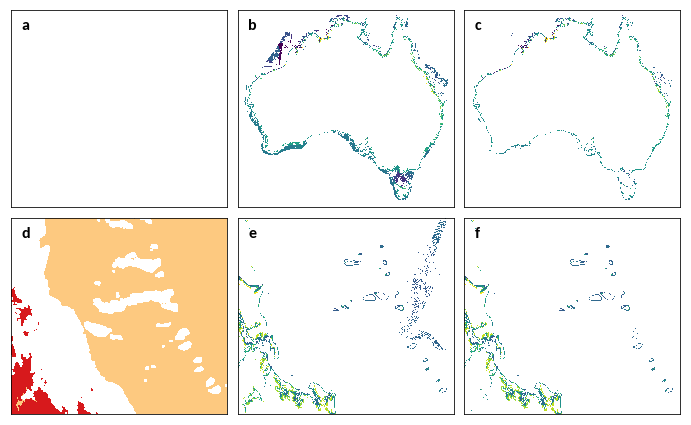

In [16]:
# Plot 
fig = plt.figure(figsize=(12, 7.45))
ax = [fig.add_subplot(2, 3, i + 1) for i in range(6)]


import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import string

# Sample data
sample_array = np.random.randint(3, size=(5,5))

# Discrete/categorical colours
cmap = colors.ListedColormap(['#2c7bb6', '#d7191c', '#fdc980'])
bounds=[0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot arrays
ax[0].imshow(np.pad(NIDEM_mask_all_array, pad_width=50, mode='constant', constant_values=np.nan), cmap=cmap, norm=norm, vmin=0, vmax=2)
ax[1].imshow(np.pad(NIDEM_unfiltered_all_array, pad_width=50, mode='constant', constant_values=np.nan), cmap='viridis', vmin=-2, vmax=2)
ax[2].imshow(np.pad(NIDEM_dem_all_array, pad_width=50, mode='constant', constant_values=np.nan), cmap='viridis', vmin=-2, vmax=2)
ax[3].imshow(NIDEM_mask_subset_array, interpolation='bilinear', cmap=cmap, norm=norm, vmin=0, vmax=2)
ax[4].imshow(NIDEM_unfiltered_subset_array, cmap='viridis', vmin=-2, vmax=2)
ax[5].imshow(NIDEM_dem_subset_array, cmap='viridis', vmin=-2, vmax=2)

for n, a in enumerate(ax):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
    a.xaxis.set_ticks_position('none') 
    a.yaxis.set_ticks_position('none') 
    a.text(0.05, 0.9, string.ascii_lowercase[n], transform=a.transAxes, fontsize=16, fontname='Carlito', fontweight='bold')

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig("figures/Comparison_figure/FigureX_sixpanelcomp.png", pad_inches = 0, dpi=300, bbox_inches='tight')

## New version of process plot

In [18]:
# Clip data to buffer 
lat, lon = -20.507, 117.91
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
x_topleft, x_bottomright = (x - 8000, x + 8000)
y_topleft, y_bottomright = (y - 8000, y + 7000)

# !gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data/r78/rt1527/nidem/output_data/geotiff/dem/NIDEM_dem /g/data/r78/rt1527/nidem/figures/Process_figure/NIDEM_dem_subset.tif
# !gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data2/v10/ITEM/rel_products/ITEM_REL_135_117.60_-20.59.tif /g/data/r78/rt1527/nidem/figures/Process_figure/ITEM_subset.tif
# !gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data/fk4/datacube/002/HLTC/HLTC_2_0/geotiff/COMPOSITE_LOW_135_117.6_-20.59_20100101_20170101_PER_20.tif /g/data/r78/rt1527/nidem/figures/Process_figure/HLTC_subset.tif

!gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data/r78/rt1527/nidem/output_data/archive/geotiff/dem/NIDEM_dem /g/data/r78/rt1527/nidem/figures/Process_figure/NIDEM_dem_subset.tif
!gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data2/v10/ITEM/rel_products/ITEM_REL_135_117.60_-20.59.tif /g/data/r78/rt1527/nidem/figures/Process_figure/ITEM_subset.tif
!gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -r average -overwrite /g/data/fk4/datacube/002/HLTC/HLTC_2_0/geotiff/COMPOSITE_LOW_135_117.6_-20.59_20100101_20170101_PER_20.tif /g/data/r78/rt1527/nidem/figures/Process_figure/HLTC_subset.tif



with rasterio.open('/g/data/r78/rt1527/nidem/figures/Process_figure/NIDEM_dem_subset.tif') as file:
    NIDEM_dem_subset_array = file.read(1)
    NIDEM_dem_subset_array[NIDEM_dem_subset_array == -9999.] = np.nan

with rasterio.open('/g/data/r78/rt1527/nidem/figures/Process_figure/ITEM_subset.tif') as file:
    ITEM_subset_array = file.read(1)
    ITEM_subset_array = ITEM_subset_array.astype('float')
    ITEM_subset_array[ITEM_subset_array == 0] = np.nan
    
with rasterio.open('/g/data/r78/rt1527/nidem/figures/Process_figure/HLTC_subset.tif') as file:
    HLTC_subset_array = file.read()

Creating output file that is 640P x 600L.
Processing input file /g/data/r78/rt1527/nidem/output_data/archive/geotiff/dem/NIDEM_dem.
Using internal nodata values (e.g. -9999) for image /g/data/r78/rt1527/nidem/output_data/archive/geotiff/dem/NIDEM_dem.
Copying nodata values from source /g/data/r78/rt1527/nidem/output_data/archive/geotiff/dem/NIDEM_dem to destination /g/data/r78/rt1527/nidem/figures/Process_figure/NIDEM_dem_subset.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 640P x 600L.
Processing input file /g/data2/v10/ITEM/rel_products/ITEM_REL_135_117.60_-20.59.tif.
Using internal nodata values (e.g. -6666) for image /g/data2/v10/ITEM/rel_products/ITEM_REL_135_117.60_-20.59.tif.
Copying nodata values from source /g/data2/v10/ITEM/rel_products/ITEM_REL_135_117.60_-20.59.tif to destination /g/data/r78/rt1527/nidem/figures/Process_figure/ITEM_subset.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file t

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


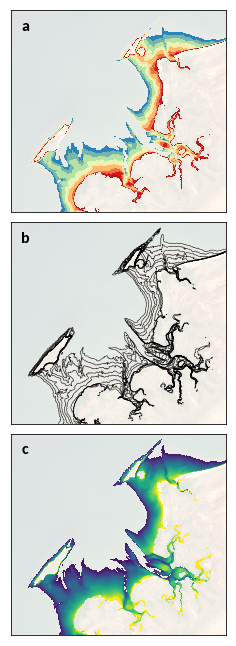

In [21]:
import copy
import string

# Plot 
fig = plt.figure(figsize=(12, 11.5))
ax = [fig.add_subplot(3, 1, i + 1) for i in range(3)]

my_cmap = copy.copy(plt.cm.get_cmap('viridis')) # get a copy of the gray color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

for n, a in enumerate(ax):
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_aspect('equal')
    a.xaxis.set_ticks_position('none') 
    a.yaxis.set_ticks_position('none') 
    a.text(0.05, 0.9, string.ascii_lowercase[n], transform=a.transAxes, fontsize=16, fontname='Carlito', fontweight='bold')

plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Plot HLTC
from skimage import exposure
import matplotlib
rawimg = np.einsum('byx->yxb', HLTC_subset_array[[2,1,0],:,:])
p2, p98 = np.percentile(rawimg, (1, 99))
img_toshow = exposure.rescale_intensity(rawimg, in_range=(p2, p98))
img_toshow2 = np.pad(img_toshow, pad_width=((94*2, 0), (100*2, 0), (0, 0)), mode='constant', constant_values=np.nan)
# ax[0].imshow(img_toshow2)

# Plot ITEM
item_cs = ['#2b83ba', '#74b6ad', '#b7e1a7', '#e7f5b7', 
           '#fee7a4', '#fdb96e', '#ec6e43', '#d7191c', '#b81518',  '#00000000']  # '#1a6a9d'
item_cm = LinearSegmentedColormap.from_list('item', item_cs, N=10)
# my_cmap = copy.copy(item_cm) # get a copy of the gray color map
item_cm.set_bad(alpha=0) # set how the colormap handles 'bad' values
ax[0].imshow(img_toshow, alpha=0.13)
ax[0].imshow(ITEM_subset_array, cmap=item_cm, interpolation='bilinear')

# Plot contours
# greytoblack_cm = colors.ListedColormap(['lightgrey', 'black'], N=500)
ax[1].imshow(img_toshow, alpha=0.13, extent=(x_topleft, x_bottomright, y_topleft, y_bottomright))
contour_shp = gpd.GeoDataFrame.from_file('/g/data/r78/rt1527/nidem/output_data/archive/contour/NIDEM_contours_135.shp')
contour_shp.plot(ax=ax[1], linewidth=0.5, column='elevation', color='black')
ax[1].set_xlim(x_topleft, x_bottomright)
ax[1].set_ylim(y_topleft, y_bottomright)

# Plot NIDEM
my_cmap = copy.copy(plt.cm.get_cmap('viridis')) # get a copy of the gray color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values
ax[2].imshow(img_toshow, alpha=0.13)
ax[2].imshow(NIDEM_dem_subset_array, cmap=my_cmap, vmin=-2, vmax=1)


plt.savefig("figures/Process_figure/FigureX_process.png", pad_inches = 0, dpi=300, bbox_inches='tight')


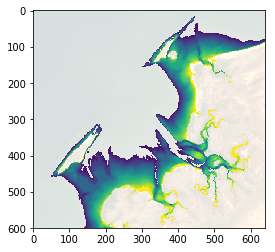

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generate some data...
gray_data = np.arange(10000).reshape(100, 100)

masked_data = np.random.random((100,100))
masked_data = np.ma.masked_where(masked_data < 0.9, masked_data)

# Overlay the two images
fig, ax = plt.subplots()
# Plot NIDEM
# Plot NIDEM

import copy
my_cmap = copy.copy(plt.cm.get_cmap('viridis')) # get a copy of the gray color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

ax.imshow(img_toshow, alpha=0.15)
ax.imshow(NIDEM_dem_subset_array, cmap=my_cmap, vmin=-2, vmax=1)


In [221]:
import matplotlib
matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)

I am densified (9 elements)
I am densified (9 elements)


,elevation,geometry
0,-1.83,"(LINESTRING (-1522737.5 -2309949.564188523, -1..."
1,-1.42,"(LINESTRING (-1442212.5 -2268200.878890254, -1..."
2,-1.01,"(LINESTRING (-1442237.5 -2268149.51901184, -14..."
3,-0.60,"(LINESTRING (-1522837.5 -2310825.021148308, -1..."
4,-0.19,"(LINESTRING (-1522862.5 -2310975.729166667, -1..."
5,0.21,"(LINESTRING (-1522887.5 -2311275.857764747, -1..."
6,0.62,"(LINESTRING (-1522887.5 -2311316.325558697, -1..."
7,1.03,"(LINESTRING (-1522887.5 -2311324.561624933, -1..."
8,1.44,"(LINESTRING (-1522887.5 -2311332.797691169, -1..."


## Combine nthaus30 payers

In [9]:
import glob
glob.glob('raw_data/nthaus30/03_ESRI_Raster/nthaus30*_26May17_v3/nthaus30?/')

['raw_data/nthaus30/03_ESRI_Raster/nthaus30b_26May17_v3/nthaus30b/',
 'raw_data/nthaus30/03_ESRI_Raster/nthaus30a_26May17_v3/nthaus30a/',
 'raw_data/nthaus30/03_ESRI_Raster/nthaus30c_26May17_v3/nthaus30c/',
 'raw_data/nthaus30/03_ESRI_Raster/nthaus30d_26May17_v3/nthaus30d/']

In [13]:

!gdalbuildvrt scratch/nthaus30.vrt /g/data1a/r78/rt1527/nidem/raw_data/nthaus30/03_ESRI_Raster/nthaus30*_26May17_v3/nthaus30?/

0...10...20...30...40...50...60...70...80...90...100 - done.


## Export NIDEM layers for 3D visualisation
Create VRTs:

In [3]:
!gdalbuildvrt /g/data/r78/rt1527/vrt/ITEM_rel.vrt /g/data2/v10/ITEM/rel_products/ITEM_REL*.tif
!gdalbuildvrt /g/data/r78/rt1527/vrt/HLTC_low.vrt /g/data/fk4/datacube/002/HLTC/HLTC_2_0/geotiff/COMPOSITE_LOW_*.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Clip to area:

In [45]:
# Clip data to buffer 
lat, lon, buffer = -21.498133, 149.384110, 20000 # Mackay
lat, lon, buffer = -20.523543, 117.916213, 10000 # pilbara
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
x_topleft, x_bottomright = (x - buffer, x + buffer)
y_topleft, y_bottomright = (y - buffer, y + buffer)

!gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -overwrite /g/data/fk4/datacube/002/NIDEM/geotiff/nidem/NIDEM.vrt visualisation/3d_files/subsets/NIDEM_dem_subset.tif
!gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -overwrite /g/data/r78/rt1527/vrt/ITEM_rel.vrt visualisation/3d_files/subsets/ITEM_rel_subset.tif
!gdalwarp -te $x_topleft $y_topleft $x_bottomright $y_bottomright -overwrite /g/data/r78/rt1527/vrt/HLTC_low.vrt visualisation/3d_files/subsets/HLTC_low_subset.tif

Creating output file that is 800P x 800L.
Processing input file /g/data/fk4/datacube/002/NIDEM/geotiff/nidem/NIDEM.vrt.
Using internal nodata values (e.g. -9999) for image /g/data/fk4/datacube/002/NIDEM/geotiff/nidem/NIDEM.vrt.
Copying nodata values from source /g/data/fk4/datacube/002/NIDEM/geotiff/nidem/NIDEM.vrt to destination visualisation/3d_files/subsets/NIDEM_dem_subset.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 800P x 800L.
Processing input file /g/data/r78/rt1527/vrt/ITEM_rel.vrt.
Using internal nodata values (e.g. -6666) for image /g/data/r78/rt1527/vrt/ITEM_rel.vrt.
Copying nodata values from source /g/data/r78/rt1527/vrt/ITEM_rel.vrt to destination visualisation/3d_files/subsets/ITEM_rel_subset.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 800P x 800L.
Processing input file /g/data/r78/rt1527/vrt/HLTC_low.vrt.
Using internal nodata values (e.g. -999) for image /g/data/r78/rt

In [139]:
import glob
import rasterio
import numpy as np
from skimage import exposure
from skimage.color import rgb2hsv, hsv2rgb
from unsharp_mask import unsharp_mask

def hsv_image_processing(rgb_array, 
                         hue_mult=1.0, sat_mult=1.15, val_mult=1.1,
                         unsharp_radius1=20, unsharp_amount1=1.0, 
                         unsharp_radius2=1, unsharp_amount2=1.0):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Apply unsharp mask and take average
    a = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius1, amount=unsharp_amount1)
    b = unsharp_mask(hsv_array[:, :, 2], radius=unsharp_radius2, amount=unsharp_amount2)
    hsv_array[:, :, 2] = np.mean( np.array([ a, b ]), axis=0)
    
    # Convert back to RGB
    return hsv2rgb(hsv_array).clip(0, 1)

study_area = 'pilbara'
item_path = 'visualisation/3d_files/subsets/ITEM_rel_subset.tif'
nidem_path = 'visualisation/3d_files/subsets/NIDEM_dem_subset.tif'
hltc_path = 'visualisation/3d_files/subsets/HLTC_low_subset.tif'

# Import layers
with rasterio.open(nidem_path) as file:
    
    nidem_array = file.read(1)
    nidem_profile = file.profile
    nidem_array[nidem_array == -9999] = np.nan

with rasterio.open(item_path) as file:
    
    item_array = file.read(1)
    item_array = item_array.astype('float')
    item_array[item_array == -6666] = np.nan
    
with rasterio.open(hltc_path) as file:
    
    hltc_array = file.read([3, 2, 1])
    hltc_profile = file.profile    
    
    hltc_array[hltc_array == -999.0] = np.nan
    p_low, p_high = np.nanpercentile(hltc_array, [0.5, 99.5])
    hltc_array = exposure.rescale_intensity(hltc_array, in_range=(p_low, p_high), out_range=(0, 1))
    hltc_array = hsv_image_processing(np.transpose(hltc_array, (1, 2, 0)))
    
    # Fix dtype and extract only first three bands
    hltc_array = (hltc_array * 10000).astype(rasterio.int16)
    hltc_array = np.transpose(hltc_array, (2, 0, 1))    
    
# NIDEM min and max
nidem_min = np.nanmin(nidem_array)
nidem_max = np.nanmax(nidem_array)

# Set lowest and highest NIDEM intervals to NIDEM mins/maxes
nidem_array[item_array == 0] = nidem_min 
nidem_array[item_array == 9] = nidem_max 

# Save outputs to file
with rasterio.open(f'visualisation/3d_files/3d_nidem_{study_area}.tif', 'w', **nidem_profile) as dst:
    dst.write(nidem_array, 1)

hltc_profile.update(dtype=rasterio.int16, compress='lzw', nodata = -9999, count = 3)
with rasterio.open(f'visualisation/3d_files/3d_hltc_{study_area}.tif', 'w', **hltc_profile) as dst:
    dst.write(hltc_array)


In [85]:
p_low, p_high

(0.014888434670865536, 0.31549757719039917)

In [91]:
with rasterio.open(hltc_path) as file:
    
    hltc_array = file.read([3, 2, 1])
    
    print(np.min(hltc_array[0]))

0.014888435


In [117]:
np.max(hltc_array[0])

4875

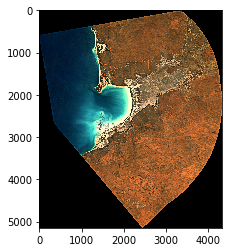

In [10]:
import matplotlib.pyplot as plt
plt.imshow(out_test)